# Capstone Project - Sentiment Analysis of German Twitter

This notebook is supposed to take a look at the data sued for the project.

## 1. Loading the data

In [55]:
!git commit -m 'Adjusted preprocessing, changed classifier'

On branch master
Your branch is behind 'origin/master' by 1 commit, and can be fast-forwarded.
  (use "git pull" to update your local branch)

Changes not staged for commit:
	deleted:    .ipynb_checkpoints/data_analysis-checkpoint.ipynb
	deleted:    data_analysis.ipynb

Untracked files:
	.ipynb_checkpoints/Sentiment Analysis for German Twitter-checkpoint.ipynb
	Sentiment Analysis for German Twitter.ipynb
	source_sklearn/

no changes added to commit


In [40]:
import pandas as pd
import os

In [41]:
tweets_df = pd.read_csv("data/downloaded.tsv", sep="\t", header=None, names=["id", "sentiment", "unknown1", "unknown2", "text"])

In [42]:
len(tweets_df.index)

9939

## 2. Preparing the data

In [43]:
cleaned_df = tweets_df[tweets_df['text'] != 'Not Available']
cleaned_df.head()

,id,sentiment,unknown1,unknown2,text
3,367189542857482240,neutral,c020aa23ff1f8ff985ce489b2b678674,[],Tainted Talents (Ateliertagebuch.) » Wir sind ...
4,368327046574776321,neutral,0096b66e311fffcca65c23d2a310083b,[],Aber wenigstens kommt #Supernatural heute mal ...
6,368309870673793024,neutral,575fd73efa41e07e2b0c360a721d19d7,[],DARLEHEN - Angebot für Schufa-freie Darlehen: ...
7,362896018389475328,neutral,8b824c765a7642a980b9e14c02830126,[],ANRUF ERWÜNSCHT: Hardcore Teeny Vicky Carrera:...
8,367912309303148545,neutral,a07f6bc77b0cfb06a75c7cb1a88d752b,[],Na? Wo sind Frankens heimliche Talente? - Die ...


In [44]:
len(cleaned_df.index)

6539

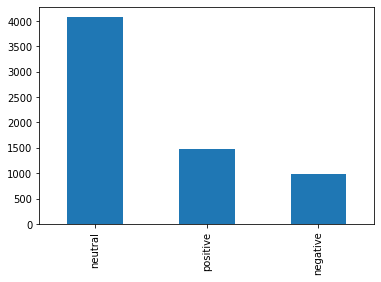

In [45]:
cleaned_df['sentiment'].value_counts().plot.bar()

In [46]:
cleaned_df['sentiment'] = cleaned_df['sentiment'].apply(
      lambda x: 2 if x == 'positive' else (0 if x == 'negative' else 1))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [47]:
from sklearn.model_selection import train_test_split

def splitting(df):
    X_train, X_test, y_train, y_test = train_test_split(df.text, df.sentiment, test_size=0.2, shuffle=False)
    return X_train, X_test, y_train, y_test

In [48]:
X_train, X_test, y_train, y_test = splitting(cleaned_df)

In [51]:
X_train.head(10)

3     Tainted Talents (Ateliertagebuch.) » Wir sind ...
4     Aber wenigstens kommt #Supernatural heute mal ...
6     DARLEHEN - Angebot für Schufa-freie Darlehen: ...
7     ANRUF ERWÜNSCHT: Hardcore Teeny Vicky Carrera:...
8     Na? Wo sind Frankens heimliche Talente? - Die ...
9                        ... Glück breitet sich aus ...
10                           @Moramee unachtsam *seufz*
11    #jobs #Sales #Medien #TV #Tele M1 sucht #Persö...
13    Happy Halloween liebe Studenten, zeigt eure gr...
14    Die App „iDelete“ hat mir 3,4 MB belegten Spei...
Name: text, dtype: object

## 3. Preprocessing the data

In [50]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import GermanStemmer
from nltk.stem.cistem import Cistem

stemmer = Cistem()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import re
from bs4 import BeautifulSoup

def review_to_words(text):
    text = text.lower() # Convert to lower case
    text = re.sub(r"http\S+", "XXXURLTOKENXXX", text) # replace links
    text = re.sub(r"@\S+", "XXXUSERNAMETOKENXXX", text) # replace mentionings with '@'
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text) # remove all numbers standing alone
    text = re.sub(r'(?<=\s)[^\s\w]*(?=[\w])', '', text) # remove punctuations preceeding words
    text = re.sub(r'[.]{2,}', '...', text) # unify consecutive periods if there are at least 2
    text = re.sub(r'(?<=\w)[^\s\w](?=[\s\w])', '', text) # remove single punctuation subceeding words (leaves emoticons)
    text = re.sub( r'([\w])([^\s\w])', r'\1 \2', text) # add white space between punctuations subceeding a word
    text = re.sub(r'(?<=\s)[^\s\w](?=[\s])', '', text) # remove single punctuation preceeding empty space (leaves emoticons)
    text = re.sub(r"#", "", text) # remove '#' in front of hashtags
    text = re.sub(r"rt ", "", text) # remove 'RT'
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("german")] # Remove stopwords
    words = [stemmer.stem(w) for w in words] # stem
    
    #from nltk.tokenize import TweetTokenizer 

    
    return words

In [53]:
review_to_words('this ia a  . wonderful. text!! 55 77.7 *seufz.')

['thi', 'ia', 'a', 'wonderful', 'tex', '!!', '77', '.7', 'seufz', '.']

In [13]:
def preprocess_data(data_train, data_test):
    """Convert each review to words; read from cache if available."""

    # Preprocess training and test data to obtain words for each review
    words_train = [review_to_words(review) for review in data_train]
    words_test = [review_to_words(review) for review in data_test]
    
    return words_train, words_test

In [14]:
X_train, X_test = preprocess_data(X_train, X_test)

In [15]:
X_train[:20]

[['tainted', 'tal', 'ateliertagebuch', '.)', 'allei', 'xxxurltokenxxx'],
 ['wenig', 'komm', 'supernatural', 'heu', 'mal', 'uhr', 'schwach', 'tro'],
 ['darleh',
  'angebo',
  'schufa',
  '-frei',
  'darleh',
  'gunstig',
  'anbie',
  'onli',
  'darleh',
  'deutschla',
  'xxxurltokenxxx'],
 ['anruf',
  'erwunsch',
  'hardcor',
  'teeny',
  'vicky',
  'carrera',
  'hallo',
  'suss',
  'jahrig',
  'vicky',
  'deutschla',
  '...',
  'xxxurltokenxxx'],
 ['na',
  'frank',
  'heimlich',
  'tal',
  'ers',
  'bewerbung',
  'talentwettbewerb',
  'wer',
  'ko',
  'darf',
  '!"...',
  'xxxurltokenxxx'],
 ['...', 'gluck', 'brei', '...'],
 ['xxxusernametokenxxx', 'unachtsam', 'seufz', '*'],
 ['job',
  'sal',
  'medie',
  'tv',
  'tel',
  'm1',
  'such',
  'personlichkei',
  'werb',
  'verkauf',
  'aussendie',
  'm',
  '/w',
  'xxxurltokenxxx'],
 ['happy', 'hallowee', 'lieb', 'stud', 'zeig', 'gruselig', 'seit', '!'],
 ['app',
  'idel',
  '3',
  ',4',
  'mb',
  'beleg',
  'speich',
  'freigemach',
  'l

In [16]:
from nltk import FreqDist

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_words = get_all_words(X_train)


freq_dist = FreqDist(all_words)
print(freq_dist.most_common(30))

[('xxxusernametokenxxx', 3166), ('xxxurltokenxxx', 2447), ('...', 866), ('.', 542), ('!', 242), ('gut', 241), ('neu', 211), ('schon', 193), ('mehr', 179), ('?', 175), ('mach', 162), ('d', 140), ('geh', 133), ('mal', 132), ('dank', 127), ('…', 124), ('heu', 117), ('bitt', 106), ('einfach', 104), ('gross', 102), ('amp', 98), ('lieb', 96), ('ja', 96), ('klei', 95), (':)', 92), ("'s", 90), ('morg', 86), ('war', 85), ('ne', 83), ('komm', 81)]


### Extract Bag-of-Words features

In [17]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=2000):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""

    # Fit a vectorizer to training documents and use it to transform them
    # NOTE: Training documents have already been preprocessed and tokenized into words;
    #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
    vectorizer = TfidfVectorizer(max_features=vocabulary_size, preprocessor=lambda x: x, tokenizer=lambda x: x)
    features_train = vectorizer.fit_transform(words_train).toarray()

    # Apply the same vectorizer to transform the test documents (ignore unknown words)
    features_test = vectorizer.transform(words_test).toarray()
    
    vocabulary = vectorizer.vocabulary_
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [18]:
# Extract Bag of Words features for both training and test datasets
X_train, X_test, vocabulary = extract_BoW_features(X_train, X_test)

In [19]:
vocabulary

{'tal': 1654,
 '.)': 60,
 'allei': 209,
 'xxxurltokenxxx': 1947,
 'wenig': 1879,
 'komm': 1014,
 'heu': 847,
 'mal': 1120,
 'uhr': 1742,
 'schwach': 1516,
 'tro': 1716,
 'darleh': 459,
 'angebo': 225,
 'schufa': 1511,
 'gunstig': 789,
 'anbie': 218,
 'onli': 1298,
 'deutschla': 484,
 'anruf': 230,
 'erwunsch': 603,
 'hallo': 809,
 'suss': 1647,
 '...': 62,
 'na': 1205,
 'frank': 685,
 'heimlich': 832,
 'ers': 599,
 'wer': 1880,
 'darf': 458,
 'gluck': 755,
 'brei': 390,
 'xxxusernametokenxxx': 1948,
 'seufz': 1540,
 '*': 26,
 'job': 947,
 'sal': 1454,
 'medie': 1139,
 'tv': 1729,
 'tel': 1665,
 'such': 1642,
 'werb': 1881,
 'verkauf': 1790,
 'm': 1110,
 '/w': 91,
 'happy': 819,
 'hallowee': 810,
 'lieb': 1084,
 'stud': 1636,
 'zeig': 1964,
 'seit': 1531,
 '!': 0,
 'app': 239,
 '3': 122,
 'mb': 1135,
 'speich': 1593,
 'losch': 1100,
 'bring': 392,
 '16': 106,
 'frei': 693,
 'tschuss': 1721,
 'moi': 1181,
 '????': 173,
 'check': 427,
 'out': 1308,
 'the': 1680,
 'new': 1242,
 'pag': 1315

## 4. Classification

In [20]:
#X_val = pd.DataFrame(X_train[:2000])
X_train = pd.DataFrame(X_train)

#y_val = pd.DataFrame(y_train[:2000])
y_train = pd.DataFrame(y_train)

In [21]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
y_train = y_train.reset_index(drop=True)
y_train.head()

,sentiment
0,1
1,1
2,1
3,1
4,1


In [23]:
# First we make sure that the local directory in which we'd like to store the training and validation csv files exists.
data_dir = '../data/sentiment_data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [24]:
# First, save the test data to test.csv in the data_dir directory. Note that we do not save the associated ground truth
# labels, instead we will use them later to compare with our model output.

pd.DataFrame(X_test).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

# Save the training and validation data to train.csv and validation.csv in the data_dir directory.
#pd.concat([y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
train_df = pd.concat([y_train, X_train], axis=1, ignore_index=True)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
train_df.to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [26]:
# To save a bit of memory we can set text_X, train_X, val_X, train_y and val_y to None.
#X_test = X_train = X_val = y_train = y_val = None

### Uploading Training / Validation files to S3

In [27]:
import sagemaker
import boto3

session = sagemaker.Session() # Store the current SageMaker session
bucket = session.default_bucket()

# S3 prefix (which folder will we use)
prefix = 'sentiment_data'

# deleting bucket, uncomment lines below
bucket_to_delete = boto3.resource('s3').Bucket(bucket)
bucket_to_delete.objects.all().delete()

# Upload the test.csv, train.csv and validation.csv files which are contained in data_dir to S3 using sess.upload_data().
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [28]:
empty_check = []

for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

sentiment_data/test.csv
sentiment_data/train.csv


### Create an Estimator

In [29]:
# your import and estimator code, here
from sagemaker.sklearn.estimator import SKLearn

In [30]:
%%time

role = sagemaker.get_execution_role()
# Train your estimator on S3 training data
sklearn_estimator = SKLearn(entry_point='train.py',
                            source_dir='source_sklearn',
                            role=role,
                            train_instance_count=1,
                            train_instance_type='ml.m4.xlarge',
                            sagemaker_session=session)
sklearn_estimator.fit({'train': 's3://sagemaker-us-east-2-920979387335/sentiment_data/train.csv',
                        'test': 's3://sagemaker-us-east-2-920979387335/sentiment_data/test.csv'})

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-14 16:14:22 Starting - Starting the training job...
2020-08-14 16:14:24 Starting - Launching requested ML instances......
2020-08-14 16:15:28 Starting - Preparing the instances for training...
2020-08-14 16:16:21 Downloading - Downloading input data...
2020-08-14 16:16:36 Training - Downloading the training image..2020-08-14 16:16:56,160 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-08-14 16:16:56,164 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-14 16:16:56,183 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-08-14 16:16:56,442 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-08-14 16:16:56,442 sagemaker-containers INFO     Generating setup.cfg
2020-08-14 16:16:56,442 sagemaker-containers INFO     Generating MANIFEST.in
2020-08-14 16:16:56,442 sagemaker-containers INFO     Installing module with the following comm

In [31]:
%%time

# deploy your model to create a predictor
predictor = sklearn_estimator.deploy(instance_type='ml.m4.xlarge', #'ml.p2.xlarge',
                                     initial_instance_count=1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 268 ms, sys: 10.4 ms, total: 278 ms
Wall time: 7min 32s


### Evaluating the model

In [32]:
# First: generate predicted, class labels
y_test_preds = predictor.predict(X_test)

# test that your model generates the correct number of labels
assert len(y_test_preds)==len(y_test), 'Unexpected number of predictions.'
print('Test passed!')

Test passed!


In [33]:
# Second: calculate the test accuracy
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print('\nAccuracy:')
print(accuracy_score(y_test, y_test_preds))

print('\nF1 macro score:')
print(f1_score(y_test, y_test_preds, average='macro'))
      
print('\nClassification report:')
print(classification_report(y_test, y_test_preds))
      
## print out the array of predicted and true labels, if you want
print('\nPredicted class labels: ')
print(y_test_preds)
print('\nTrue class labels: ')
print(y_test.values)

print('\n Confusion matrix:')
print(confusion_matrix(y_test, y_test_preds, normalize='true'))


Accuracy:
0.735474006116208

F1 macro score:
0.5813747503888349

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.22      0.32       180
           1       0.76      0.92      0.83       832
           2       0.69      0.52      0.59       296

    accuracy                           0.74      1308
   macro avg       0.67      0.56      0.58      1308
weighted avg       0.72      0.74      0.71      1308


Predicted class labels: 
[1 1 1 ... 1 1 2]

True class labels: 
[1 1 1 ... 0 1 2]

 Confusion matrix:
[[0.22222222 0.65555556 0.12222222]
 [0.02163462 0.92307692 0.05528846]
 [0.0472973  0.43243243 0.52027027]]


In [34]:
# uncomment and fill in the line below!
predictor.delete_endpoint()